In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

The notebook explores the following 3 questions:
1.  What are the days of the week on which people are most likely to miss their appointment?
2. Is sending SMS effective in helping improve present rate?
3. What is the relationship between age and show rate?

# Data Wrangling

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


At the first glance, there are a few questions related to the dataframe:
 - The datatype of PatientId is weird, making the information difficult to read
 - There are hour/minute/second information without correct input in the "AppointmentDay" column.
 - The "no-show" column should be converted to the type of boolean or integer to make further analysis easier.
 - The format of column name should be uniform to make further coding easier.

In [3]:
# change column name format
df.rename(columns = lambda x: x.lower(), inplace = True)
df.rename(columns = lambda x: x.replace('-',"_"), inplace = True)

In [4]:
# check null value
df.isnull().sum()

patientid         0
appointmentid     0
gender            0
scheduledday      0
appointmentday    0
age               0
neighbourhood     0
scholarship       0
hipertension      0
diabetes          0
alcoholism        0
handcap           0
sms_received      0
no_show           0
dtype: int64

There is no null value in the dataset.

In [5]:
# check unique values for each column
for i in df.columns:
    print(i, len(df[i].unique()))

patientid 62299
appointmentid 110527
gender 2
scheduledday 103549
appointmentday 27
age 104
neighbourhood 81
scholarship 2
hipertension 2
diabetes 2
alcoholism 2
handcap 5
sms_received 2
no_show 2


It indicates that there are a few patients with multiple appointment records, since the total number of patient ID is fewer than that of the appointment ID. To make the patient ID more readable, let's convert it's datatype from "float" to "int".

In [6]:
df.patientid = df.patientid.astype(int)

The "age" variable is right scewed, and a minority of the patients are without alcoholism, diabetes, handicap, hipertension and scholarship. Besides, a majority of the patients do not receive SMS.

In [7]:
df.no_show.value_counts()

No     88208
Yes    22319
Name: no_show, dtype: int64

Most of the patients on record did not show up for their appointment.

# Data Cleaning

## 1. Change datetime datatype

The "appointment date" and "scheduled date" columns are of object data type. It would be better if we change them into datetime object.

In [8]:
# First only get the date because the hour and minute is useless
df.appointmentday = pd.to_datetime(df.appointmentday).dt.date
df.scheduledday = pd.to_datetime(df.scheduledday).dt.date

# change the date to datetime object
df.appointmentday = pd.to_datetime(df.appointmentday)
df.scheduledday = pd.to_datetime(df.scheduledday)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patientid         110527 non-null int64
appointmentid     110527 non-null int64
gender            110527 non-null object
scheduledday      110527 non-null datetime64[ns]
appointmentday    110527 non-null datetime64[ns]
age               110527 non-null int64
neighbourhood     110527 non-null object
scholarship       110527 non-null int64
hipertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handcap           110527 non-null int64
sms_received      110527 non-null int64
no_show           110527 non-null object
dtypes: datetime64[ns](2), int64(9), object(3)
memory usage: 11.8+ MB


Since all of the columns have same number of raws, there are no missing values in the dataset.

## 2. Deal with categorical datatype

In [9]:
# map no show column
df.no_show = df.no_show.map(dict(Yes=0, No=1))
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1


In [10]:
df['dayofweek'] = df.appointmentday.dt.dayofweek
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,dayofweek
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,4
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,4
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,4
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,4
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,4


Convert 'gender' column to 1/0 variables.

In [11]:
# deal with gender column
df.gender = df.gender.map(dict(M=0, F=1))
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,dayofweek
0,29872499824296,5642903,1,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,4
1,558997776694438,5642503,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,4
2,4262962299951,5642549,1,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,4
3,867951213174,5642828,1,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,4
4,8841186448183,5642494,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,4


## 3. Check Outliers

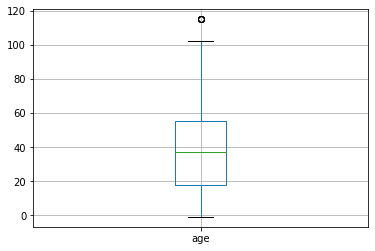

In [12]:
df.boxplot(column = ['age'])

In [13]:
df.age.describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

The boxplot and description statistics shows that there are minus age and age larger than 100. These could be outliers for the dataframe. To reduce the influnce of those outliers on our final result, we could drop raws where age is larger than 100 and smaller than 0.

In [14]:
# drop raws where age is larger than 100 and smaller than 0
df = df[(df['age']>=0) & (df['age']<=100)]

## 4. Drop duplicates

In [15]:
df.drop_duplicates(inplace = True)

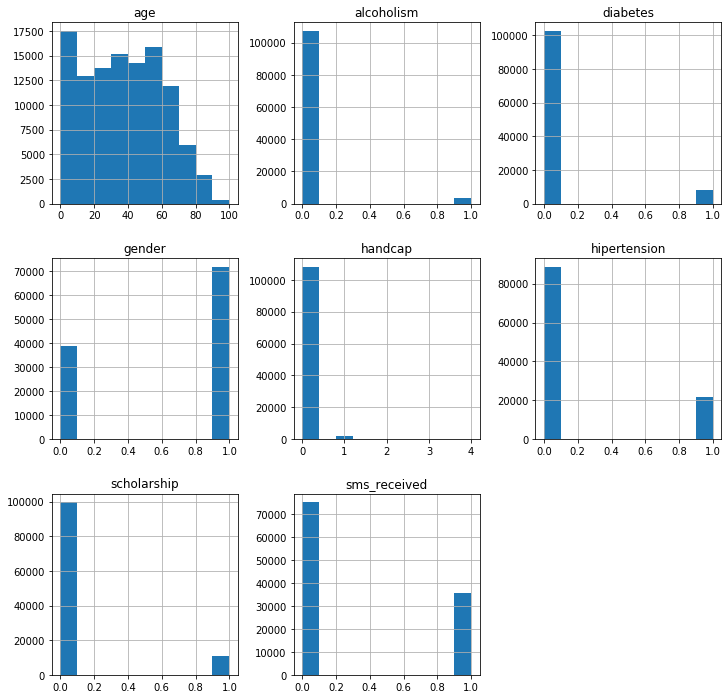

In [16]:
# data wrangling
plot_column = ['age', 'gender', 'alcoholism', 'diabetes', 'handcap', 'hipertension', 'scholarship', 'sms_received']
df[plot_column].hist(figsize = (12,12));

The spread of 'age' is pretty right skewed. The other features are either 1-0 variables or extent indicated by integers. Generally speaking, the number of patients without certain diseases is larger than number of patients with those diseases.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110519 entries, 0 to 110526
Data columns (total 15 columns):
patientid         110519 non-null int64
appointmentid     110519 non-null int64
gender            110519 non-null int64
scheduledday      110519 non-null datetime64[ns]
appointmentday    110519 non-null datetime64[ns]
age               110519 non-null int64
neighbourhood     110519 non-null object
scholarship       110519 non-null int64
hipertension      110519 non-null int64
diabetes          110519 non-null int64
alcoholism        110519 non-null int64
handcap           110519 non-null int64
sms_received      110519 non-null int64
no_show           110519 non-null int64
dayofweek         110519 non-null int64
dtypes: datetime64[ns](2), int64(12), object(1)
memory usage: 13.5+ MB


In [18]:
df.shape

(110519, 15)

After the data cleaning process, there are 11059 rows and 16 columns in the dataframe.

# Exploring Data

## 1. What are the days of the week on which people are most likely to miss their appointment?

In [19]:
# write a function to calculate the show rate for a certain feature
def show_percent(group_by_col):
    allrecord = df.groupby(group_by_col)['patientid'].count()
    showrecord = df[df['no_show'] == 1].groupby(group_by_col)['patientid'].count()
    percent_show = showrecord/allrecord
    return percent_show

In [20]:
percent_show = show_percent('dayofweek')

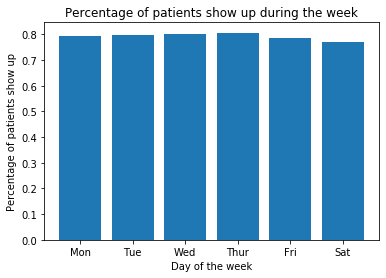

In [21]:
location = [1,2,3,4,5,6]
height = percent_show
lb = ['Mon','Tue','Wed','Thur','Fri', 'Sat']

plt.bar(location, height, tick_label = lb)
plt.title('Percentage of patients show up during the week')
plt.xlabel('Day of the week')
plt.ylabel('Percentage of patients show up');

It seems that the patients are more likely to miss appointments on Friday and Saturday. To make the trend more observable, let's visualize the same data by line chart.

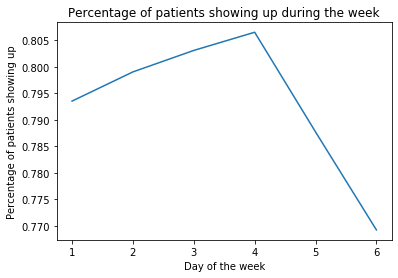

In [22]:
# use line chart to make the differences more observable
location = [1,2,3,4,5,6]
height = percent_show
lb = ['Mon','Tue','Wed','Thur','Fri', 'Sat']

plt.plot(location, height)
plt.title('Percentage of patients showing up during the week')
plt.xlabel('Day of the week')
plt.ylabel('Percentage of patients showing up');

The two images above show that patients are more likely to miss appointments on weekends (Saturday and Friday). Let's group weekdays into two categories -- weekdays and weekends, and check and compare the show rate for both groups.

In [23]:
def weekday_or_not(row):
    if row['dayofweek'] <=3:
        return 1
    else:
        return 0

In [24]:
df['weekday'] = df.apply(lambda row: weekday_or_not(row), axis = 1)

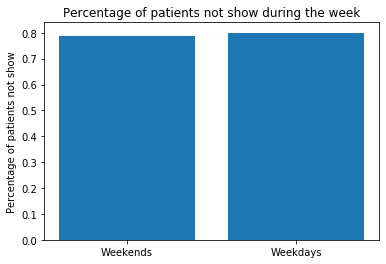

In [25]:
location = [1,2]
height = show_percent('weekday')
lb2 = ['Weekends', 'Weekdays']

plt.bar(location, height, tick_label = lb2)
plt.title('Percentage of patients not show during the week')
plt.ylabel('Percentage of patients not show');

Since "0" represents Friday and Saturday, the analysis indicates that people are less likely to show up on Friday and Sturday, and more likely to show up on weekdays.

## 2. Is SMS effective in improving present rate?

Firstly, let's see whether the people who receive or not receive SMS are concentrated in a certain type of people.

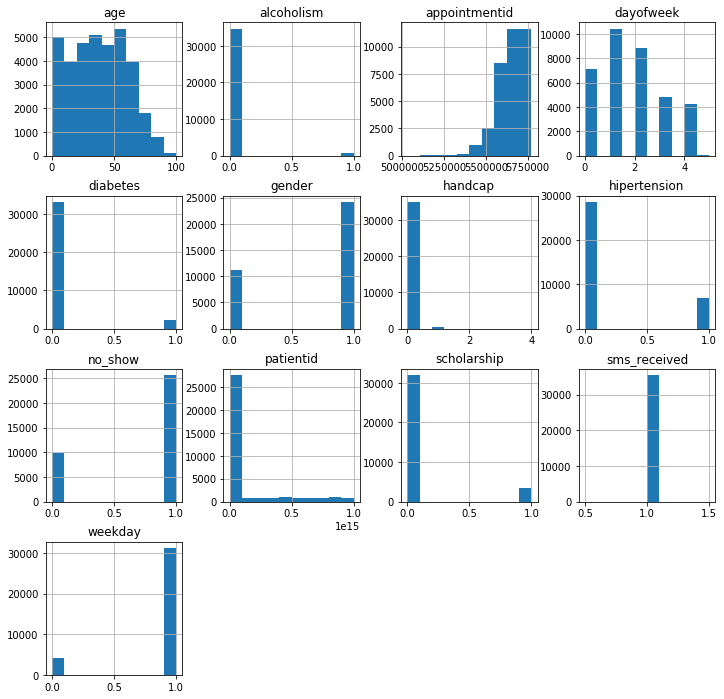

In [26]:
df[df['sms_received']==1].hist(figsize = (12,12));

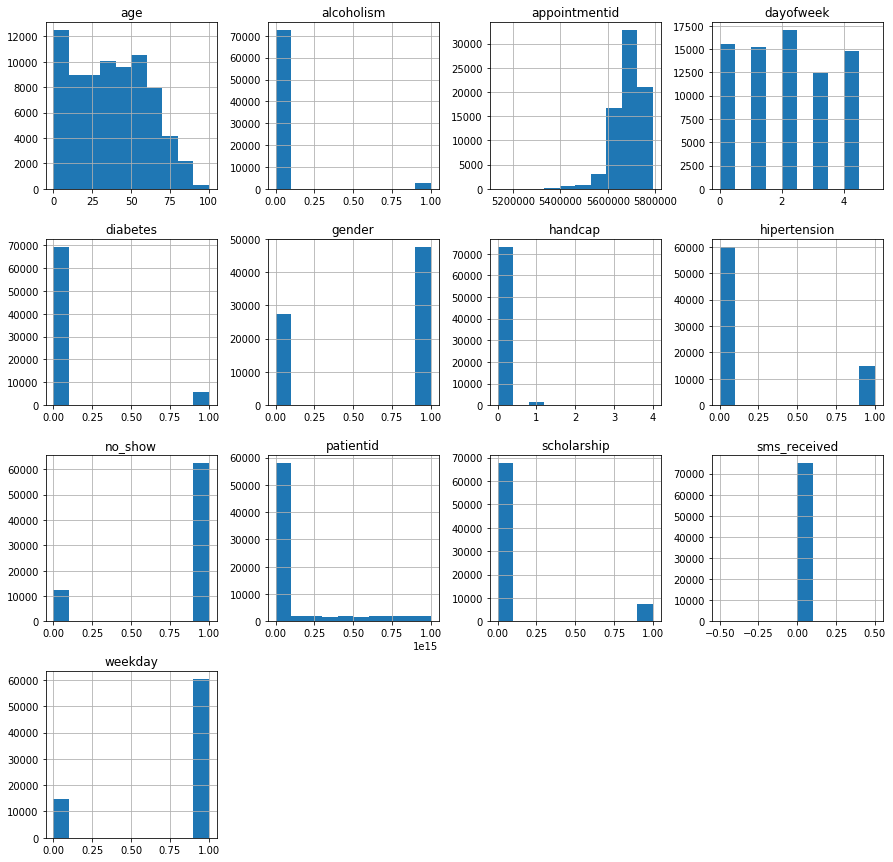

In [27]:
df[df['sms_received']==0].hist(figsize = (15,15));

The major difference between the group of people who receive SMS and those who did not is in the "dayofweek" feature. The patients who receive SMS are concentrated in those whose appointment is on Monday to Wednesday, and those who did not receive SMS show a more even spread from Monday to Friday. Since the and the prior analysis indicates that day of the week is an important factor that would influence show up rate, we divide the 2 dataframe into 2 groups: Monday-Wednesday and Thursday - Saturday.

In [28]:
df_mw = df[(df['dayofweek']==0) | (df['dayofweek']==1) | (df['dayofweek']==2)]
df_ts = df[df['dayofweek']>3]

In [29]:
# deal with monday-wednesday dataset
# yes=0=not show up; no=1=show up
# percentage of people who receive SNS and show up
receive_show = df_mw[df_mw['sms_received']==1]['no_show'].sum()/df_mw[df_mw['sms_received']==1].shape[0]
# percentage of people who did not receive SNS and show up
noreceive_show = df_mw[df_mw['sms_received']==0]['no_show'].sum()/df_mw[df_mw['sms_received']==0].shape[0]
receive_show,noreceive_show

(0.7251249432076329, 0.8394762163745136)

For the first group, the patients who receive SMS are 0.72 likely to show up, and who did not receive SMS are 0.83 likely to show up.

In [30]:
# deal with thursday - saturday dataset
receive_show2 = df_ts[df_ts['sms_received']==1]['no_show'].sum()/df_ts[df_ts['sms_received']==1].shape[0]
# percentage of people who did not receive SMS and show up
noreceive_show2 = df_ts[df_ts['sms_received']==0]['no_show'].sum()/df_ts[df_ts['sms_received']==0].shape[0]
receive_show2,noreceive_show2

(0.7280909521553766, 0.8046511627906977)

For the second group, the patients who receive SMS are 0.73 likely to show up, and who did not receive SMS are 0.8 likely to show up.

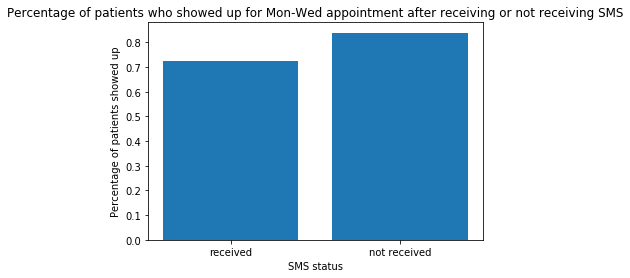

In [31]:
location3 = [1,2]
height3 = [receive_show, noreceive_show]
lb3 = ['received', 'not received']

plt.bar(location3, height3, tick_label = lb3)
plt.title('Percentage of patients who showed up for Mon-Wed appointment after receiving or not receiving SMS')
plt.xlabel('SMS status')
plt.ylabel('Percentage of patients showed up');

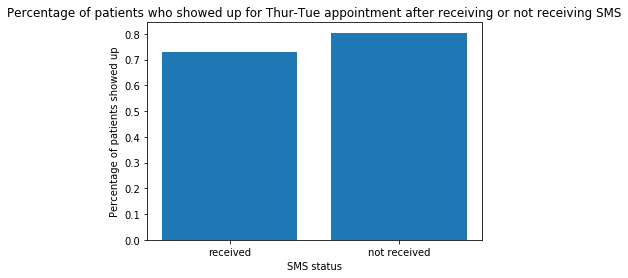

In [32]:
location3 = [1,2]
height3 = [receive_show2, noreceive_show2]
lb3 = ['received', 'not received']

plt.bar(location3, height3, tick_label = lb3)
plt.title('Percentage of patients who showed up for Thur-Tue appointment after receiving or not receiving SMS')
plt.xlabel('SMS status')
plt.ylabel('Percentage of patients showed up');

The bar charts for two datasets both indicate that the percentage of people showing up did not increase because of SMS. We could probably infer that the reason why people miss appointment is not that they forget it, and the absent is caused by their own decisions.

## 3. What is the relationship between age and show rate?

In [33]:
df_age = df.groupby('age')['no_show'].sum().reset_index()
df_age.head()

,age,no_show
0,0,2900
1,1,1858
2,2,1366
3,3,1236
4,4,1017


In [34]:
df_age.iloc[0, 1]

2900

In [35]:
# calculate the show rate for each age
df_total = df.groupby('age')['patientid'].count().reset_index()
showrate_list = []
for i in df_age.index:
    total_app = df_total.iloc[i,1]
    show = df_age.iloc[i,1]
    show_rate = show/total_app
    showrate_list.append(show_rate)

In [36]:
# add the list to a new column 
df_age['show_rate'] = showrate_list
df_age.head()

,age,no_show,show_rate
0,0,2900,0.819441
1,1,1858,0.817422
2,2,1366,0.844252
3,3,1236,0.816920
4,4,1017,0.782910


In [37]:
df_age.show_rate.describe()

count    101.000000
mean       0.809401
std        0.050488
min        0.717352
25%        0.771654
50%        0.811321
75%        0.838415
max        1.000000
Name: show_rate, dtype: float64

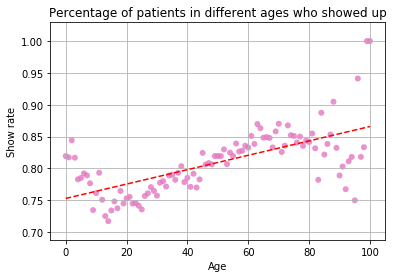

In [38]:
# draw a scatter plot to visualize the relationship
x = df_age.age
y = df_age.show_rate
plt.scatter(x, y, c='tab:pink', alpha=0.8, edgecolors='none')
plt.grid(True)

plt.title('Percentage of patients in different ages who showed up')
plt.xlabel('Age')
plt.ylabel('Show rate');

# Draw a trend line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

The plot and the trend line show that, generally speaking, the older patients tend to show up for their appointments more often. But there are divergent and float within the trend. To look deeper into the trend, we could use a line chart to observe the trend:

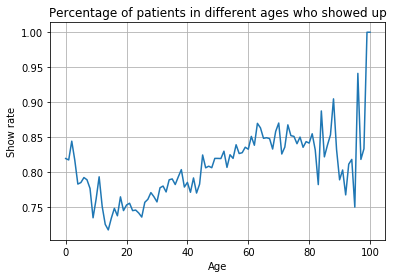

In [39]:
# draw a line chart to visualize the relationship
location_age = range(df_age.shape[0])

plt.grid(True)
plt.title('Percentage of patients in different ages who showed up')
plt.xlabel('Age')
plt.ylabel('Show rate')
plt.plot(location_age, y);

Generally speaking, for patients of 20 to 80 years old, the show rate increases with the increase of age, which means the older the patient, the higher the likelihood they would show up. For patients of 0 to 20 years old, the show rate decrease as the age increase, which means the older the patient, the lower the likelihood that they would show up. For patients of 80 to 100 years old, the likelihood of their showing up for an appointment is less predictable.

# Conclusion

In summary, patients are less likely to show up on Friday and Sturday, and more likely to show up on Monday to Thursday. Besides, sending SMS does not appear to be effective in improving the rate that patients show up. As for how people in different ages act about attending an appointment, it was found that for patients from 20 to 80 years old, the older the patient, the higher the likelihood they would show up. For patients from 0 to 20 years old, the older the patient, the lower the likelihood that they would show up. 

# Limitations:

- Limitation 1: There is no data for Sunday, and the dataframe and introduction did not provide us with the reason why there is an absent of data for Sunday. Without such data, the conclusion draw on the difference weekdays and weekends could be less reliable.

- Limitation 2: The data didn't provide the content of SMS. So we cannot interpret whether it was the content of the SMS not effective in reminding the patients of their appointment, or it was because the patients deliberately missed the appointment.

- Limitation 3: The data for age is right skewed, which means that the number of sample for older patients might not be large enough for us to draw a conclusion for 60-100 year-old patients. 

# Reference

1. Map columns: https://stackoverflow.com/questions/40901770/is-there-a-simple-way-to-change-a-column-of-yes-no-to-1-0-in-a-pandas-dataframe
2. Scatter plot: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/scatter_with_legend.html
3. Draw trend line: https://stackoverflow.com/questions/41635448/how-can-i-draw-scatter-trend-line-on-matplot-python-pandas/41635626
4. Add value to new column based on value of other columns: https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o